# Capstone Project 2
## Predicting Women's Clothing Reviews

In [52]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
%matplotlib inline  
pd.set_option('max_columns', 100)

nlp = spacy.load('en', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maris\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Data Cleaning/Wrangling

In [2]:
#importing data
data=pd.read_csv('Womens_Clothing_E-Commerce_Reviews.csv', index_col=0)
pd.options.display.max_colwidth=0
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [3]:
data.isnull().sum()

Clothing ID                0   
Age                        0   
Title                      3810
Review Text                845 
Rating                     0   
Recommended IND            0   
Positive Feedback Count    0   
Division Name              14  
Department Name            14  
Class Name                 14  
dtype: int64

In [4]:
data['Title']=data['Title'].fillna(" ")

In [5]:
#creating new variable with the title and review text together
data['title_review']=data['Title']+' '+data['Review Text']

In [6]:
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,title_review
0,767,33,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comfortable
1,1080,34,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite."
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,"Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!


In [7]:
data['Class Name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms', nan, 'Chemises'], dtype=object)

## Exploratory Analysis

In [8]:
#descriptive data on the numerical variables
data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      23486 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
title_review               22641 non-null object
dtypes: int64(5), object(6)
memory usage: 2.2+ MB


[Text(0,0.5,'Frequency')]

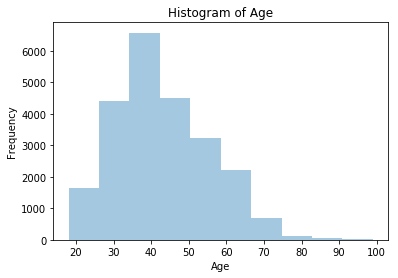

In [10]:
plt.title('Histogram of Age')
ax=sns.distplot(data["Age"],bins=10, kde=False)
ax.set(ylabel='Frequency')

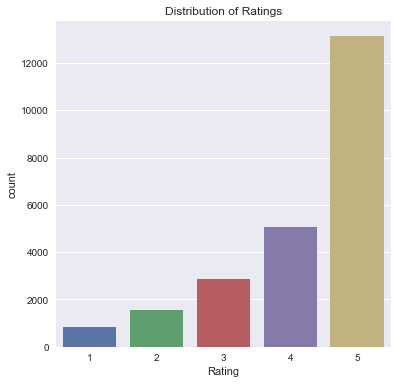

In [11]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Ratings')
sns.countplot(x = 'Rating', data = data)

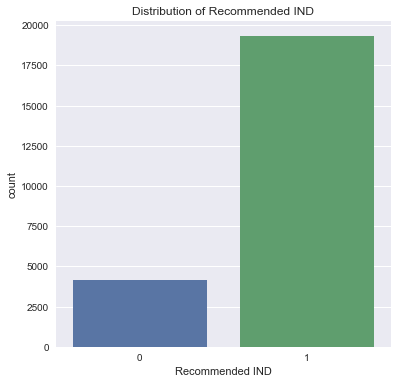

In [12]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Recommended IND')
sns.countplot(x = 'Recommended IND', data = data)

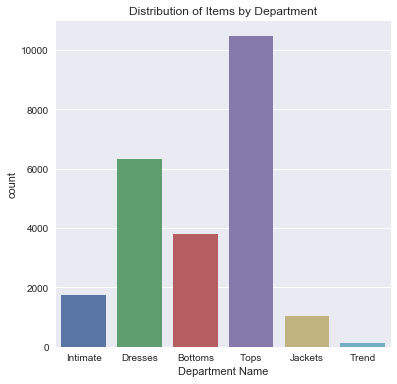

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Items by Department')
sns.countplot(x = 'Department Name', data = data)

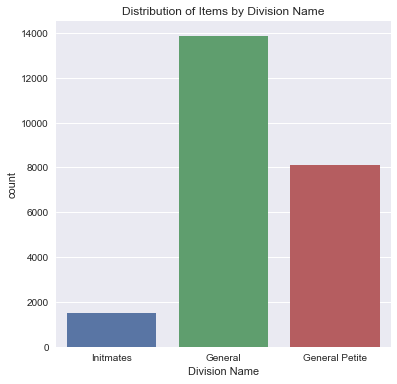

In [14]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Items by Division Name')
sns.countplot(x = 'Division Name', data = data)

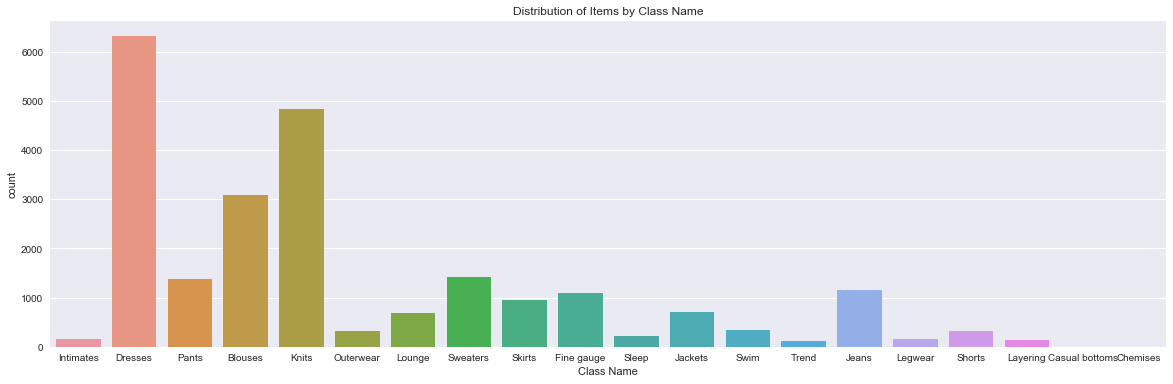

In [15]:
sns.set(rc={'figure.figsize':(20,6)})
plt.title('Distribution of Items by Class Name')
sns.countplot(x = 'Class Name', data = data)

In [16]:
#'Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
 #      'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
  #     'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
   #    'Casual bottoms', nan, 'Chemises'

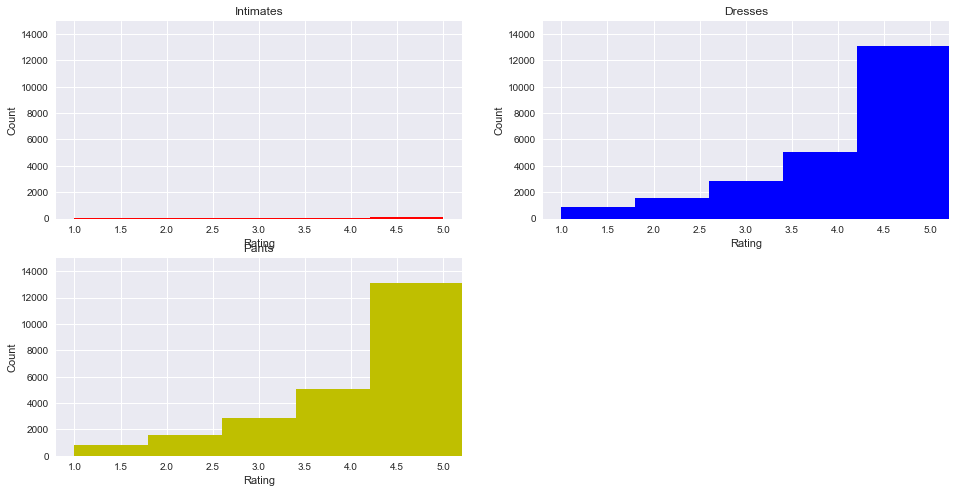

In [17]:
#Is there an easier way to do this?

Intimates=data[data['Class Name'] =='Intimates']
Intimates=Intimates.Rating
Dresses=data[data['Class Name'] =='Dresses']
Dresses=data.Rating
Pants=data[data['Class Name'] =='Pants']
Pants=data.Rating
bins = 5

fig=plt.figure()
fig.set_size_inches(16, 8)
ax1=fig.add_subplot(2,2, 1)
ax2=fig.add_subplot(2,2, 2)
ax3=fig.add_subplot(2,2, 3)
ax1.hist(Intimates, bins, histtype='bar', rwidth=1, color='r')
ax2.hist(Dresses, bins, histtype='bar', width=1, color="b")
ax3.hist(Pants, bins, histtype='bar', width=1, color="y")
ax1.title.set_text('Intimates')
ax1.set_xlabel("Rating")
ax1.set_ylabel("Count")
ax1.set_ylim(bottom=0, top=15000)
ax2.title.set_text('Dresses')
ax2.set_xlabel("Rating")
ax2.set_ylabel("Count")
ax2.set_ylim(bottom=0, top=15000)
ax3.title.set_text('Pants')
ax3.set_xlabel("Rating")
ax3.set_ylabel("Count")
ax3.set_ylim(bottom=0, top=15000)
plt.show()

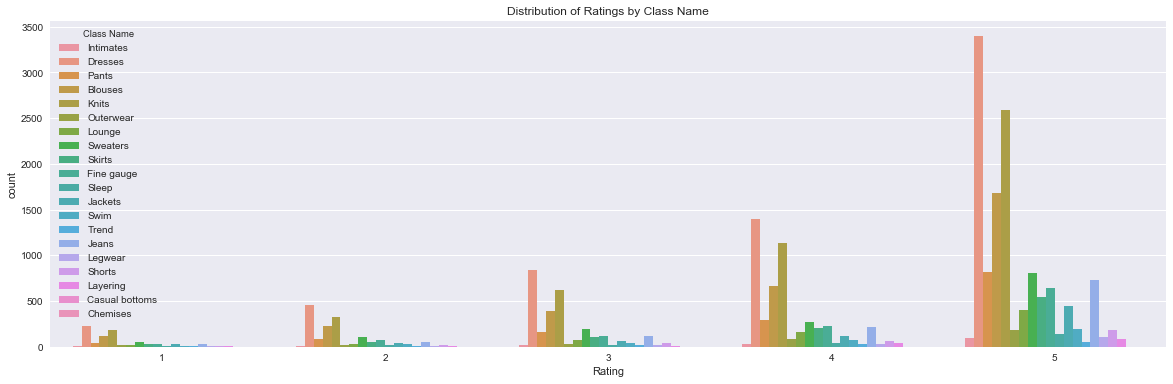

In [18]:
sns.set(rc={'figure.figsize':(20,6)})
plt.title('Distribution of Ratings by Class Name')
sns.countplot(x="Rating", hue="Class Name", data=data)

Text(0,0.5,'Count')

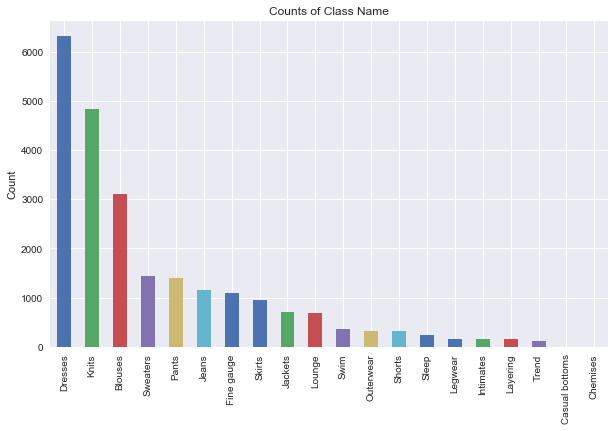

In [19]:
sns.set(rc={'figure.figsize':(10,6)})
ax=data['Class Name'].value_counts().plot(kind='bar')
plt.title('Counts of Class Name')
ax.set_ylabel("Count")


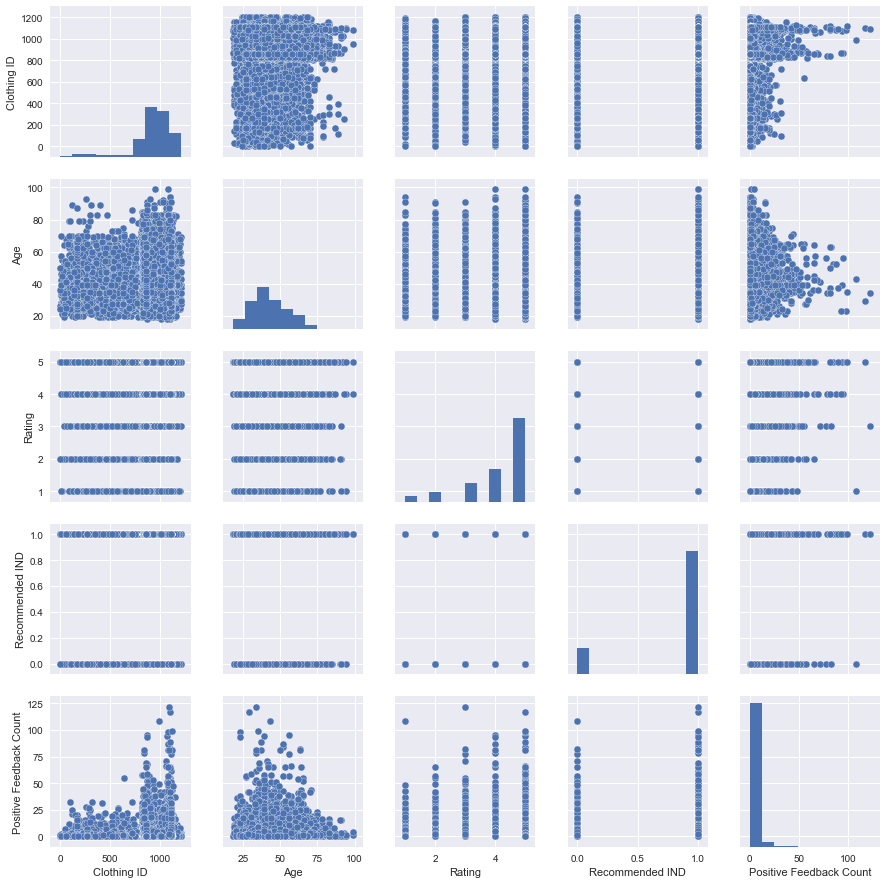

In [20]:
sns.pairplot(data)

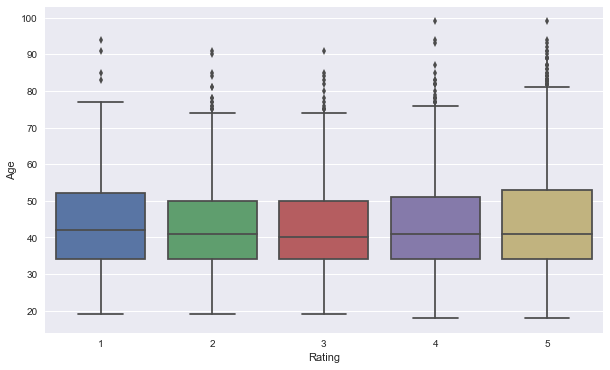

In [21]:
sns.boxplot(x="Rating", y="Age", data=data)

C:\Users\maris\Anaconda3\envs\pymar\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


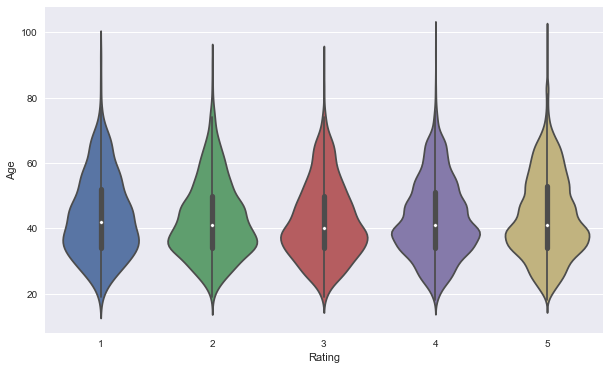

In [22]:
sns.violinplot(x="Rating", y="Age", data=data)

In [28]:
wordcloud = WordCloud().generate(str(data['title_review']))

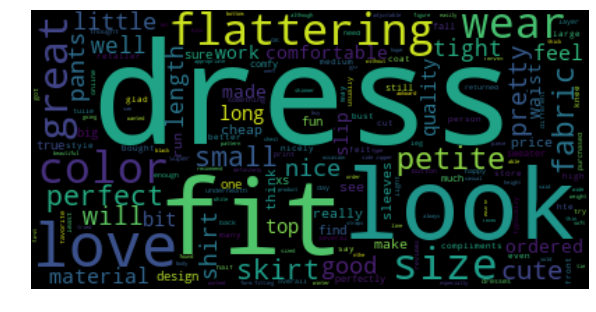

In [29]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Wrangling and Pre-processing

In [55]:
#defining steps of data cleaning

#remove accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#removing special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

#stemming words
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

#lemmatizing the text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

#removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [56]:
#defining text normalizer
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [65]:
# pre-process text and store the same
data['clean_text'] = normalize_corpus(data['title_review'])
norm_corpus= list(data['clean_text'])

# show a sample news article
data.iloc[1][['full_text', 'clean_text']].to_dict()

TypeError: normalize() argument 2 must be str, not float